In [1]:
import numpy as np
from g3_utils import g3utils as ut
import matplotlib.pyplot as plt
from spt3g import core
import pathlib

In [2]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

ra_df_added = control_computer_g3_dir / "mapmaking/ra_df_added.g3"
norm_df_added = control_computer_g3_dir / "mapmaking/norm_df_added.g3"

In [3]:
# create non-normalized df and compute stats

stats = ut.DetectorStats(data_key="df")
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.AddScanDF)
pipe.Add(stats)
pipe.Add(ut.FrameCounter)
pipe.Run()
# see signal_analysis.ipynb for plots of this data
detector_medians = np.median(np.array(stats.medians), axis=0)
detector_stds = np.median(np.array(stats.stds), axis=0)


Calibration
PipelineInfo
Scan (x117)
EndProcessing


In [4]:
# Uncomment this pipeline to recompute & overwrite ra_df_added/norm_df_added

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.add_radec_so3g)
pipe.Add(ut.AddScanDF)
pipe.Add(ut.add_cal_lamp_df, iq_key="cal_lamp_data")
pipe.Add(core.G3Writer, filename=str(ra_df_added))
pipe.Add(ut.NormalizeDF, detector_medians=detector_medians)
pipe.Add(core.G3Writer, filename=str(norm_df_added))
pipe.Add(ut.FrameCounter)
pipe.Run()

"""
Pipeline profiling results:
spt3g.core.G3Reader: 0.071389 user, 0.037763 system, 120 frames (0.000910 s per input frame)
_pipelineinfo: 0.000000 user, 0.000000 system, 120 frames (0.000000 s per input frame)
g3utils.add_radec_so3g: 0.197547 user, 0.000434 system, 120 frames (0.001650 s per input frame)
g3utils.AddScanDF: 25.434544 user, 0.064807 system, 120 frames (0.212495 s per input frame)
g3utils.add_cal_lamp_df: 0.281990 user, 0.009692 system, 120 frames (0.002431 s per input frame)
g3utils.NormalizeDF: 0.253910 user, 0.000002 system, 120 frames (0.002116 s per input frame)
g3utils.FrameCounter: 0.003378 user, 0.000064 system, 120 frames (0.000029 s per input frame)
spt3g.core.G3Writer: 3.151443 user, 0.251032 system, 120 frames (0.028354 s per input frame)
Total: 29.394201 user, 0.363794 system
Peak memory consumption (369.4 MB) in module g3utils.add_cal_lamp_df
""";


Calibration
PipelineInfo
Scan (x117)
EndProcessing


In [5]:
def first_frame(file, type=core.G3FrameType.Scan):
    grabber = ut.FirstFrameGrabber(frame_type=type)
    pipe = core.G3Pipeline()
    pipe.Add(core.G3Reader, filename=file)
    pipe.Add(grabber)
    pipe.Run()
    return grabber.first_frame

kids: np.ndarray[str] = np.array(first_frame(str(norm_df_added))["norm_df"].names)
kids.sort()

In [6]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

# map dimensions
xlen = 1.4 * core.G3Units.deg
ylen = 0.9 * core.G3Units.deg

# pixel resolution
res = 1 * core.G3Units.arcmin

In [7]:
source_coords = {}
# determine source shifts
binners = [
    ut.SingleMapBinner(
        kid,
        timestreams="df",
        ra0=ra0,
        dec0=dec0,
        xlen=xlen,
        ylen=ylen,
        res=res
    ) for kid in kids
]

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
for binner in binners:
    pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

for kid, binner in zip(kids, binners):
    source_coords[kid] = binner.source_coords()


Calibration
PipelineInfo
Scan (x117)
EndProcessing



Calibration
PipelineInfo
Scan (x117)
EndProcessing


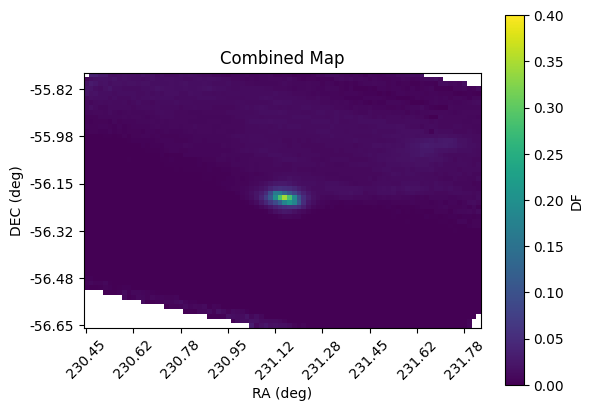

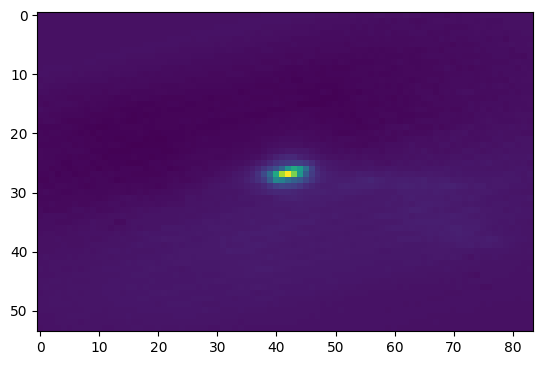

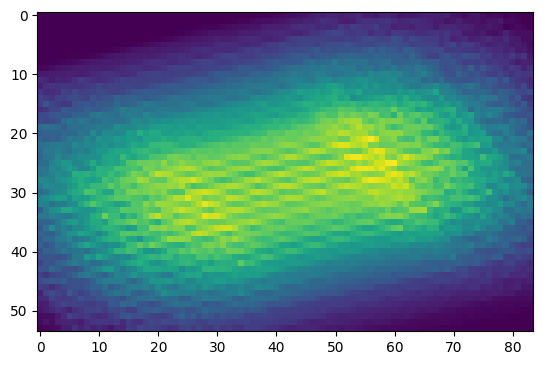

In [8]:
class MapBinner:
    def __init__(self, timestreams="df", source_coords: dict=None, standard_deviations: list=None,
                 ra0=None, dec0=None, xlen=None, ylen=None, res=None, 
                 select_kids: list[str] = None):
        self.timestreams = timestreams
        self.source_coords = source_coords
        self.standard_deviations = standard_deviations
        assert source_coords is not None, "must set source_coords!"
        assert ra0 is not None, "must set ra0!"
        assert dec0 is not None, "must set dec0!"

        self.ra0 = ra0
        self.dec0 = dec0
        self.xlen = xlen if xlen is not None else 1 * core.G3Units.deg
        self.ylen = ylen if ylen is not None else 1 * core.G3Units.deg
        self.res = res if res is not None else 1 * core.G3Units.arcmin
        # number of bins along each axis
        self.nx = int(self.xlen / self.res)
        self.ny = int(self.ylen / self.res)
        # bin edges
        self.ra_edges = np.linspace(-self.xlen / 2, self.xlen / 2, self.nx + 1) + self.ra0
        self.dec_edges = np.linspace(-self.ylen / 2, self.ylen / 2, self.ny + 1) + self.dec0

        self.select_kids = select_kids

        # array for storing the binned timestream data
        self.data = np.zeros((self.ny, self.nx), dtype=float)
        # array for storing the number of times each pixel is "hit" in the timestreams
        self.hits = np.zeros((self.ny, self.nx), dtype=float)

    def _get_kids(self, super_ts) -> list[str]:
        """Determine the list of kids which should contribute to the map

        Returned KIDs exisit in both:
        - detector timestream data
        - select_kids, if provided
        """
        if self.select_kids is None: return super_ts.names
        return list(set(super_ts.names).intersection(set(self.select_kids)))

    def __call__(self, frame):
        if self.timestreams not in frame:
            return

        super_ts = frame[self.timestreams]

        common_kids = self._get_kids(super_ts)

        for kid in common_kids:
            kid_timestream_idx = int(np.where(np.asarray(super_ts.names) == kid)[0][0])
            kid_ts = super_ts.data[kid_timestream_idx]
            
            x = frame["ra"] + (self.nx / 2 - self.source_coords[kid][0]) * self.res
            y = frame["dec"] + (self.ny / 2 - self.source_coords[kid][1]) * self.res

            # update data and hits, in-place
            if self.standard_deviations is not None:
                kid_weight = self.standard_deviations[kid_timestream_idx]**-2  # same index as super_ts
            else:
                kid_weight = 1
            kid_data = np.histogram2d(y, x, bins=[self.dec_edges, self.ra_edges], weights=kid_ts)[0] * kid_weight
            self.data += kid_data
            kid_hits = np.histogram2d(y, x, bins=[self.dec_edges, self.ra_edges])[0] * kid_weight
            self.hits += kid_hits

    def plot(self, ax=None):
        with np.errstate(invalid='ignore'):
            m = self.data / self.hits
        if ax is not None:
            ax.imshow(m, origin='lower')
            ax.set_xticks(range(self.nx + 1)[::10], [f"{ra:.2f}" for ra in self.ra_edges[::10] / core.G3Units.deg],
                          rotation=45)
            ax.set_yticks(range(self.ny + 1)[::10], [f"{dec:.2f}" for dec in self.dec_edges[::10] / core.G3Units.deg])
            ax.set_xlabel("RA (deg)")
            ax.set_ylabel("DEC (deg)")
            ax.set_title("Combined Map")
        else:
            plt.imshow(m, origin='lower', vmin=0, vmax=0.4)
            plt.xticks(range(self.nx + 1)[::10], [f"{ra:.2f}" for ra in self.ra_edges[::10] / core.G3Units.deg],
                       rotation=45)
            plt.yticks(range(self.ny + 1)[::10], [f"{dec:.2f}" for dec in self.dec_edges[::10] / core.G3Units.deg])
            plt.colorbar(label="DF")
            plt.xlabel("RA (deg)")
            plt.ylabel("DEC (deg)")
            plt.title("Combined Map")
            plt.show()

kid_rejects = [11, 21, 57, 81, 111, 127, 147, 148, 149, 150, 151, 152, 154, 158, 170, 181, 182, 192, 195,
              211, 223, 225, 245, 263, 282, 286, 293, 297, 319, 327, 331, 333, 334, 336, 337, 340, 341, 349, 352]

binner = MapBinner(
    timestreams="norm_df",
    source_coords=source_coords,
    # standard_deviations=detector_stds,
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res,
    select_kids=[f"roach1_{kid:04}" for kid in range(381) if kid not in kid_rejects]
)

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

binner.plot()

plt.imshow(binner.data); plt.show()
plt.imshow(binner.hits); plt.show()